# Figure comparing weights, pressures and star formation rate surface densities for Figure 13 in Jeffreson et al. 2024b

In [1]:
import numpy as np
import h5py
from scipy.stats import binned_statistic_2d

import sys, glob, re

sys.path.append('../')
import astro_helper as ah

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

# Load the data

In [62]:
# vlM
files_vlM = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/LOW-ETGs/vlM-PRFM/output/snap_*.hdf5')
files_vlM = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in files_vlM], files_vlM))]
files_vlM = files_vlM[5:]
print(len(files_vlM))

# lowM
files_lowM = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/LOW-ETGs/lowM-PRFM/output/snap_*.hdf5')
files_lowM = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in files_lowM], files_lowM))]
files_lowM = files_lowM[5:]
print(len(files_lowM))

# medM
files_medM = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/LOW-ETGs/medM-PRFM/output/snap_*.hdf5')
files_medM = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in files_medM], files_medM))]
files_medM = files_medM[5:]
print(len(files_medM))

# hiM
files_hiM = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/LOW-ETGs/hiM-PRFM/output/snap_*.hdf5')
files_hiM = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in files_hiM], files_hiM))]
files_hiM = files_hiM[5:]
print(len(files_hiM))

56
56
56
43


In [63]:
def collect_tau_deps(files):
    width_kpc = 4.
    tau_deps, SFRs = [], []
    for file in files:
        f = h5py.File(file, "r")
        SFR = f['PartType0']['StarFormationRate'][:] * f['PartType0']['StarFormationRate'].attrs['to_cgs']
        mass = f['PartType0']['Masses'][:] * f['PartType0']['Masses'].attrs['to_cgs']
        x = (f['PartType0']['Coordinates'][:,0] - f['Header'].attrs['BoxSize'] / 2.) * f['PartType0']['Coordinates'].attrs['to_cgs']
        y = (f['PartType0']['Coordinates'][:,1] - f['Header'].attrs['BoxSize'] / 2.) * f['PartType0']['Coordinates'].attrs['to_cgs']
        R = np.sqrt(x**2 + y**2)

        cnd = (SFR > 0) & (R/ah.kpc_to_cm < width_kpc/2.)
        mass = mass[cnd]
        SFR = SFR[cnd]

        tau_dep = mass / SFR
        SFRs.extend(list(SFR))
        tau_deps.extend(list(tau_dep))
    SFRs = np.array(SFRs)
    tau_deps = np.array(tau_deps)
    return tau_deps, SFRs

In [64]:
tau_deps_vlM, SFRs_vlM = collect_tau_deps(files_vlM)
tau_deps_lowM, SFRs_lowM = collect_tau_deps(files_lowM)
tau_deps_medM, SFRs_medM = collect_tau_deps(files_medM)
tau_deps_hiM, SFRs_hiM = collect_tau_deps(files_hiM)

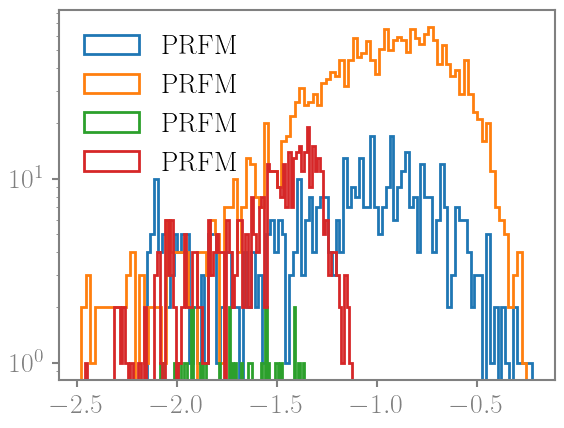

In [65]:
plt.hist(np.log10(tau_deps_vlM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.hist(np.log10(tau_deps_lowM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.hist(np.log10(tau_deps_medM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.hist(np.log10(tau_deps_hiM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.legend(frameon=False, loc='upper left')
plt.show()

In [66]:
# dynamical time of star-forming gas
def collect_tau_dyns_prfm(files):
    width_kpc = 4.
    tau_dyns = []
    for file in files:
        f = h5py.File(file, "r")
        SFR = f['PartType0']['StarFormationRate'][:] * f['PartType0']['StarFormationRate'].attrs['to_cgs']
        x = ((f['PartType0']['Coordinates'][:,0] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs'])
        y = ((f['PartType0']['Coordinates'][:,1] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs'])
        R = np.sqrt(x**2 + y**2)
        PDE = f['PartType0/PDE'][:]
        SigmaGas = f['PartType0/SigmaGas'][:]
        sigmaEff = f['PartType0/Veldisp'][:]
        
        cnd = (SFR > 0) & (R/ah.kpc_to_cm < width_kpc/2.)
        PDE = PDE[cnd]
        SigmaGas = SigmaGas[cnd]
        sigmaEff = sigmaEff[cnd]

        tau_dyn = SigmaGas*sigmaEff/PDE * f['Header'].attrs['UnitLength_in_cm'] / f['Header'].attrs['UnitVelocity_in_cm_per_s']
        tau_dyns.extend(list(tau_dyn))
    tau_dyns = np.array(tau_dyns)
    return tau_dyns

In [67]:
tau_dyns_vlM = collect_tau_dyns_prfm(files_vlM)
tau_dyns_lowM = collect_tau_dyns_prfm(files_lowM)
tau_dyns_medM = collect_tau_dyns_prfm(files_medM)
tau_dyns_hiM = collect_tau_dyns_prfm(files_hiM)

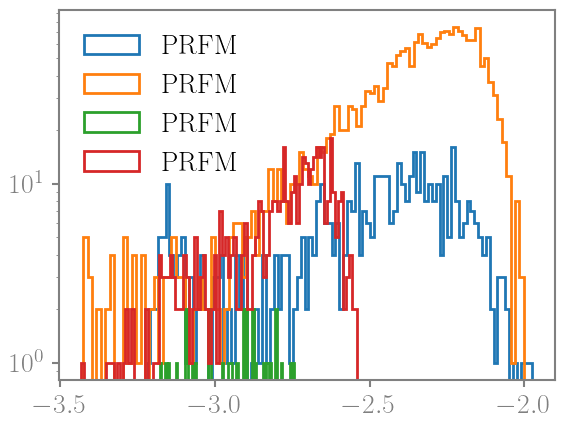

In [68]:
plt.hist(np.log10(tau_dyns_vlM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.hist(np.log10(tau_dyns_lowM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.hist(np.log10(tau_dyns_medM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.hist(np.log10(tau_dyns_hiM/ah.Gyr_to_s), bins=100, histtype='step', lw=2, label='PRFM', log=True)
plt.legend(frameon=False, loc='upper left')
plt.show()

# figure

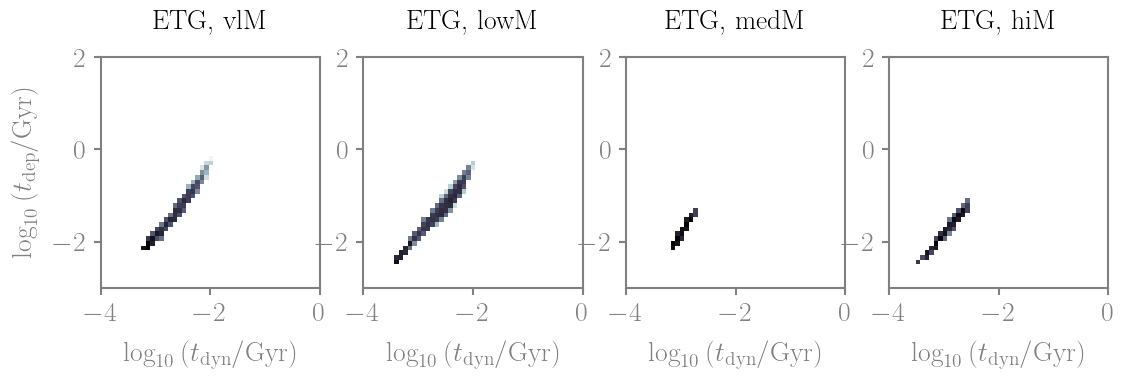

In [73]:
# 2D histogram of tau_dyn (x-axis) vs. tau_dep (y-axis) for PRFM and control (SH03) case,
# on two separate axes
fig, ax = plt.subplots(1, 4, figsize=(13,3))

# hist2D with log scale on 3rd axis
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns_vlM/ah.Gyr_to_s), np.log10(tau_deps_vlM/ah.Gyr_to_s),
    SFRs_vlM, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[0].imshow(frac_SFR.T, origin='lower',
             extent=(-4., 0., -3., 2.), aspect='auto',
             cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[0].set_xlabel(r'$\log_{10}{(t_{\rm dyn}/{\rm Gyr})}$')
ax[0].set_ylabel(r'$\log_{10}{(t_{\rm dep}/{\rm Gyr})}$')
ax[0].set_title('ETG, vlM', pad=20, fontsize=20)

frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns_lowM/ah.Gyr_to_s), np.log10(tau_deps_lowM/ah.Gyr_to_s),
    SFRs_lowM, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[1].imshow(frac_SFR.T, origin='lower',
             extent=(-4., 0., -3., 2.), aspect='auto',
             cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[1].set_xlabel(r'$\log_{10}{(t_{\rm dyn}/{\rm Gyr})}$')
ax[1].set_title('ETG, lowM', pad=20, fontsize=20)

frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns_medM/ah.Gyr_to_s), np.log10(tau_deps_medM/ah.Gyr_to_s),
    SFRs_medM, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[2].imshow(frac_SFR.T, origin='lower',
             extent=(-4., 0., -3., 2.), aspect='auto',
             cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[2].set_xlabel(r'$\log_{10}{(t_{\rm dyn}/{\rm Gyr})}$')
ax[2].set_title('ETG, medM', pad=20, fontsize=20)

frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns_hiM/ah.Gyr_to_s), np.log10(tau_deps_hiM/ah.Gyr_to_s),
    SFRs_hiM, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
ax[3].imshow(frac_SFR.T, origin='lower',
             extent=(-4., 0., -3., 2.), aspect='auto',
             cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[3].set_xlabel(r'$\log_{10}{(t_{\rm dyn}/{\rm Gyr})}$')
ax[3].set_title('ETG, hiM', pad=20, fontsize=20)

plt.show()